In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import keras

from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [36]:
df = pd.read_csv('../datas.csv', sep=',', index_col='id')

subjects = ['calculus', 'algebra', 'discrete', 'ode', 'complex', 'programming',
            'stat', 'pde', 'functional', 'variational', 'random_proc', 'numerical']
years = [13, 14, 15, 16, 17]

df['course'] = [4] * 60 + [2] * 20 + [1] * 20
df['mean'] = df[subjects].mean(axis=1)
df['round'] = np.rint(df['mean'].values)

df.loc[df['year'] == 13, 'k'] = 0.8
df.loc[df['year'] == 14, 'k'] = 0.5
df.loc[df['year'] >= 15, 'k'] = 0.3

In [53]:
subject_courses = {
    1: ['calculus', 'algebra', 'discrete'],
    2: ['calculus', 'algebra', 'discrete', 'ode', 'complex', 'programming'],
    3: ['calculus', 'algebra', 'discrete', 'ode', 'complex', 'programming', 
        'stat', 'pde', 'functional'],
    4: ['calculus', 'algebra', 'discrete', 'ode', 'complex', 'programming', 
        'stat', 'pde', 'functional', 'variational', 'random_proc', 'numerical']
}

years = [13, 14, 15, 16, 17]
train_data = []


for index, row in df.iterrows():
    for i in range(1, 4):
        # [1] -> 2, [1,2] -> 3, [1, 2, 3] -> 4
        
        current_subjects = row[subject_courses[i]]
        if current_subjects.isnull().values.any():
            continue
        
        previous_mean = current_subjects.mean()
        next_subjects = row[subject_courses[i+1]]
        
        if next_subjects.isnull().values.any():
            continue
            
        next_mean = next_subjects.mean()

        train_data.append(dict(
            ege=row['ege'],
            k=row['k'],
            course=i,
            prev_mean=previous_mean,
            next_mean=next_mean,
            year=row['year']
        ))

train_df = pd.DataFrame(train_data)

x_train = train_df[['ege', 'k', 'prev_mean', 'course']].values
y_train = train_df['next_mean'].values

In [4]:
# model = load_model('student_best_by_mean_prediction.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [151]:
max_features = 300

model = Sequential()
model.add(Embedding(max_features, output_dim=4))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 4)           1200      
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                17664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 18,929
Trainable params: 18,929
Non-trainable params: 0
_________________________________________________________________


In [152]:
history = model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=1, shuffle=True)

Epoch 1/100
200/200 [==============================] - 2s 9ms/step - loss: 14.4321 - mean_squared_error: 14.4321
Epoch 2/100
200/200 [==============================] - 0s 76us/step - loss: 14.0816 - mean_squared_error: 14.0816
Epoch 3/100
200/200 [==============================] - 0s 87us/step - loss: 13.7186 - mean_squared_error: 13.7186
Epoch 4/100
200/200 [==============================] - 0s 66us/step - loss: 13.3458 - mean_squared_error: 13.3458
Epoch 5/100
200/200 [==============================] - 0s 105us/step - loss: 12.8920 - mean_squared_error: 12.8920
Epoch 6/100
200/200 [==============================] - 0s 70us/step - loss: 12.3440 - mean_squared_error: 12.3440
Epoch 7/100
200/200 [==============================] - 0s 72us/step - loss: 11.7462 - mean_squared_error: 11.7462
Epoch 8/100
200/200 [==============================] - 0s 87us/step - loss: 11.0331 - mean_squared_error: 11.0331
Epoch 9/100
200/200 [==============================] - 0s 61us/step - loss: 10.1839 - me

200/200 [==============================] - 0s 42us/step - loss: 0.2711 - mean_squared_error: 0.2711
Epoch 74/100
200/200 [==============================] - 0s 57us/step - loss: 0.2911 - mean_squared_error: 0.2911
Epoch 75/100
200/200 [==============================] - 0s 54us/step - loss: 0.2990 - mean_squared_error: 0.2990
Epoch 76/100
200/200 [==============================] - 0s 65us/step - loss: 0.2681 - mean_squared_error: 0.2681
Epoch 77/100
200/200 [==============================] - 0s 44us/step - loss: 0.3237 - mean_squared_error: 0.3237
Epoch 78/100
200/200 [==============================] - 0s 54us/step - loss: 0.3320 - mean_squared_error: 0.3320
Epoch 79/100
200/200 [==============================] - 0s 50us/step - loss: 0.3256 - mean_squared_error: 0.3256
Epoch 80/100
200/200 [==============================] - 0s 40us/step - loss: 0.3012 - mean_squared_error: 0.3012
Epoch 81/100
200/200 [==============================] - 0s 51us/step - loss: 0.3055 - mean_squared_error: 0.3

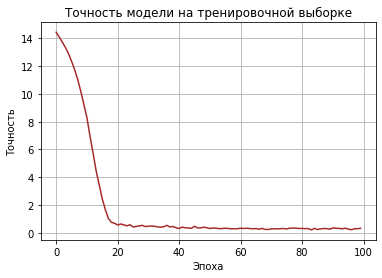

In [153]:
plt.plot(history.history['mean_squared_error'], color='brown')
plt.grid()
plt.title('Точность модели на тренировочной выборке')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.savefig('model_acc_stud.png', dpi=300)

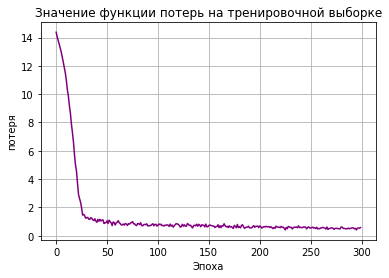

In [141]:
plt.plot(history.history['loss'], color='purple')
plt.grid()
plt.title('Значение функции потерь на тренировочной выборке')
plt.ylabel('потеря')
plt.xlabel('Эпоха')
plt.savefig('model_loss_stud.png', dpi=300)

### Прогнозирование для 2016 года 2 на  курс

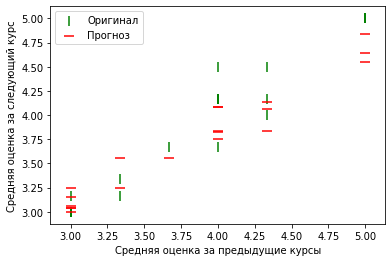

In [142]:
df_16 = train_df[train_df['year'] == 16][['ege', 'k', 'prev_mean', 'course', 'next_mean']]
x_test_16 = df_16[['ege', 'k', 'prev_mean', 'course']].values
y_test_16 = df_16['next_mean'].values

y_predict_16 = model.predict(x_test_16)

marker_size = [100 for i in range(len(x_test_16))]
plt.scatter(x_test_16[:, 2], y_test_16, marker='|', color='green', s=marker_size)
plt.scatter(x_test_16[:, 2], y_predict_16, marker='_', color='red', s=marker_size)

plt.legend(['Оригинал', 'Прогноз'])

plt.xticks(np.arange(3, 5.25, 0.25))
plt.yticks(np.arange(3, 5.25, 0.25))

plt.xlabel('Средняя оценка за предыдущие курсы')
plt.ylabel('Средняя оценка за следующий курс')

plt.savefig('16_1_to_2.png', dpi=300)

### Прогнозирование для 15 года на 4 курс

/home/roman/PycharmProjects/Example/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


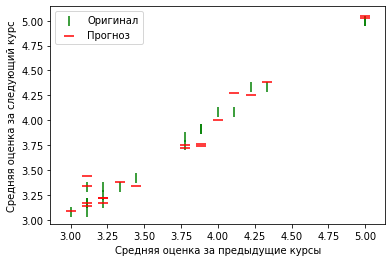

In [133]:
df_15 = train_df[train_df['year'] == 15][train_df['course']==3][['ege', 'k', 'prev_mean', 'course', 'next_mean']]
x_test_15 = df_15[['ege', 'k', 'prev_mean', 'course']].values
y_test_15 = df_15['next_mean'].values

y_predict_15 = model.predict(x_test_15)

marker_size = [100 for i in range(len(x_test_15))]
plt.scatter(x_test_15[:, 2], y_test_15, marker='|', color='green', s=marker_size)
plt.scatter(x_test_15[:, 2], y_predict_15, marker='_', color='red', s=marker_size)

plt.legend(['Оригинал', 'Прогноз'])
plt.xticks(np.arange(3, 5.25, 0.25))
plt.yticks(np.arange(3, 5.25, 0.25))
plt.xlabel('Средняя оценка за предыдущие курсы')
plt.ylabel('Средняя оценка за следующий курс');

### Рекуррентное применение модели для прогноза средней успеваемости потоков 2016 и 2017 года

In [154]:
x_test_16 = df[df['year'] == 16].copy()
x_test_16['prev_mean'] = x_test_16[subject_courses[2]].mean(axis=1)

for i in range(1, 4):
    x_test_16['course'] = i
    print(x_test_16['prev_mean'])
    y_predict = model.predict(x_test_16[['ege', 'k', 'prev_mean', 'course']].values)
    x_test_16['prev_mean'] = y_predict

x_test_17 = df[df['year'] == 17].copy()
x_test_17['prev_mean'] = x_test_17[subject_courses[1]].mean(axis=1)
x_test_17['course'] = 1
x_test_17 = x_test_17[['ege', 'k', 'prev_mean', 'course']]


for i in range(1, 4):
    x_test_17['course'] = i
    y_predict = model.predict(x_test_17[['ege', 'k', 'prev_mean', 'course']].values)
    x_test_17['prev_mean'] = y_predict

id
61    5.000000
62    5.000000
63    5.000000
64    4.166667
65    4.166667
66    4.000000
67    4.500000
68    4.166667
69    4.500000
70    3.666667
71    4.166667
72    3.666667
73    3.333333
74    3.166667
75    3.166667
76    3.000000
77    3.000000
78    3.000000
79    3.000000
80    3.000000
Name: prev_mean, dtype: float64
id
61    4.454691
62    4.474194
63    4.689369
64    3.759385
65    4.045276
66    3.891833
67    4.205786
68    4.164430
69    4.071756
70    3.715938
71    3.765553
72    3.564116
73    3.697009
74    3.266806
75    3.144987
76    3.266806
77    3.028860
78    3.063514
79    2.890319
80    3.028860
Name: prev_mean, dtype: float32
id
61    4.202425
62    4.222026
63    4.437600
64    3.429658
65    4.041903
66    3.560733
67    4.202425
68    4.161072
69    4.068397
70    3.712542
71    3.435770
72    3.560733
73    3.693612
74    3.263435
75    3.141633
76    3.263435
77    3.025515
78    3.060167
79    2.998450
80    3.025515
Name: prev_mean, dtype: flo

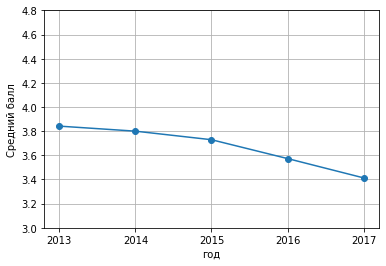

In [155]:
mean_rating_by_flow = {}

for year in years:
    mean_rating_by_flow[int("20{}".format(year))] = (df[df['year'] == year][['mean']].sum() / 20).values[0]

mean_rating_by_flow[int("20{}".format(16))] = x_test_16['prev_mean'].mean()
mean_rating_by_flow[int("20{}".format(17))] = x_test_17['prev_mean'].mean()

x = mean_rating_by_flow.keys()
y = mean_rating_by_flow.values()
plt.errorbar(x, y, marker='o')

plt.ylabel('Средний балл')
plt.xlabel('год')

plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.yticks(np.arange(3, 5, 0.2))
plt.grid()
plt.savefig('mean_by_flow_with_prediction.png', dpi=300)

In [62]:
# model.save('student_believable_by_mean_prediction.h5')